In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson
import numpy as np
import torch
import torch.nn as nn
import math

In [2]:
class Utils:
    # Convert string parameter into torch activation function
    @staticmethod
    def get_activation_function(activation_function_str, negative_slope):
        if activation_function_str == "Lrelu":
            activation = torch.nn.LeakyReLU(negative_slope=negative_slope)
        elif activation_function_str == "relu":
            activation = torch.nn.ReLU()
        elif activation_function_str == "sigmoid":
            activation = torch.nn.Sigmoid()
        else:
            raise ValueError("Activation function not recognized : {}".format(activation_function_str))
        return activation
    
    # Convert string parameter into torch final activation function
    @staticmethod
    def get_final_activation_function(final_activation):
        if final_activation == "Sigmoid":
            final_activation = lambda x: torch.sigmoid(x)
        elif final_activation == "Clamping":
            final_activation = lambda x: torch.clamp(x, min=0., max=1.)
        elif final_activation == "Linear":
            final_activation = lambda x: x
        else:
            raise ValueError("final_activation must be Sigmoid, Clamping or Linear")
        return final_activation
    

In [3]:
class Conditional_Poisson_Generator(nn.Module):
    def __init__(self,
                 noise_size: int=1,
                 min_mu: int=1,
                 max_mu: int=1,
                 hidden_dim: int=100,
                 activation_function: str="Lrelu",
                 final_activation: str="Sigmoid",
                 label_size: int=10,
                 negative_slope: float=0.1,
                 nb_hidden_layers_G: int=1,
                 eps: float=0.,
                 **kwargs):
        super(Conditional_Poisson_Generator, self).__init__()
        self.min_mu = min_mu
        self.max_mu = max_mu
        self.input_dim = noise_size
        self.nb_hidden_layers = nb_hidden_layers_G
        self.hidden_dim = hidden_dim
        self.activation = Utils.get_activation_function(activation_function, negative_slope)
        self.input_noise = nn.Linear(self.input_dim, self.hidden_dim)
        self.label_size = label_size
        self.input_label = nn.Linear(1, self.label_size)
        self.fcs = nn.ModuleList()
        self.eps = eps
        for i in range(self.nb_hidden_layers):
            if i == 0:
                self.fcs.append(nn.Linear(self.hidden_dim + self.label_size, self.hidden_dim))
            else:
                self.fcs.append(nn.Linear(self.hidden_dim, self.hidden_dim))
        self.output = nn.Linear(self.hidden_dim, 1)
        self.final_activation = Utils.get_final_activation_function(final_activation)
         
    def forward(self, x, mu):
        # Normalize mu with min_mu and max_mu into [0, 1]
        if self.max_mu == self.min_mu:
            mu = 1
        else:
            mu = (mu - self.min_mu) / (self.max_mu - self.min_mu)       
        return self.feed_forward(x, mu)
    
    def feed_forward(self, x, mu):
        x = self.activation(self.input_noise(x))
        mu = self.activation(self.input_label(mu))
        x = torch.cat((x, mu), 1)
        for i in range(self.nb_hidden_layers):
            x = self.activation(self.fcs[i](x))
        x = self.final_activation(self.output(x))
        return x + self.eps

def get_M(alpha, mu):
    poisson_distribution_get_M = poisson.rvs(mu, size=2000000)
    poisson_comp_distribution_get_M = np.array([np.sum(np.random.rand(i)) for i in poisson_distribution_get_M])
    return math.ceil(np.quantile(poisson_comp_distribution_get_M, alpha))

In [6]:
params = {}

# tested_mus are mu values on which we will perform tests (KS divergence)
params["tested_mus"] = [3, 5, 6, 7, 8, 9, 10, 20, 30, 50]
# Set min_mu == max_mu to train on one value for mu; otherwise, it will train on the interval and parametrize G and D 
params["min_mu"] = 3
params["max_mu"] = 60
# alpha: poisson.ppf(alpha) is network's max return value.
# Because network return values are bounded in [0,1], 1 has to have a draw equivalent which is poisson.ppf(alpha)
params["alpha"] = 0.999
# Networks parameters
# Number of uniform draws for G
params["noise_size"] = 5
# Hidden layer size for mu inputs when parametrized (leaving it at 10 is satisfactory)
params["label_size"] = 10
# "Lrelu", "relu" or "sigmoid" (default Lrelu with negative slope 0.1)
params["activation_function"] = "Lrelu"
params["negative_slope"] = 0.1
# Final activation for Generator: Sigmoid, Linear or Clamping
params["final_activation"] = "Sigmoid"
# hidden layer size
params["hidden_dim"] = 100
# number of hidden layers for both D and G after input layer (default 1) : total number of hidden layers is nb_hidden_layers + 1
params["nb_hidden_layers_G"] = 1
params["nb_hidden_layers_D"] = 1


# Path parameters
params["load_dir_model"] = "checkpoints_PoissonCompUniform"



# CUDA (might not work, to be tested)
params["device"] = torch.device('cuda:0')
params["cuda"] = False
# In case cuda = True, pick GPU number :
%env CUDA_VISIBLE_DEVICES = 0

env: CUDA_VISIBLE_DEVICES=0


In [7]:
poissonComp_checkpoint = torch.load(params['load_dir_model'], map_location='cpu')
poissonComp_generator = Conditional_Poisson_Generator(**params).to('cpu')
poissonComp_generator.load_state_dict(poissonComp_checkpoint['generator_state_dict'])
print(poissonComp_checkpoint['epoch'])
M = poissonComp_checkpoint['QuantileAlpha']

111


Load the best model (PATH should be like "models_poisson/poisson_mu-0.1-20_finalactivation-linear/checkpoints" . poisson_generator need to get the same features.

In [8]:
def PoissonComp_generator(G, mu, noise_size, size,  max_mu, M, device, **kwargs) :
    G = G.to(device)
    if mu > max_mu:
            _mu = max_mu
    else:
        _mu = mu
    partial_uniforms = torch.rand(size, noise_size, device = device)
    tensor_mu = torch.ones(size, 1, device = device)*_mu
    simulated_poissonComp_draws = G(partial_uniforms, tensor_mu)*M
    if mu > _mu:
        simulated_poissonComp_draws = (simulated_poissonComp_draws- _mu/2) / np.sqrt(_mu/3) * np.sqrt(mu/3) + mu/2    
    return simulated_poissonComp_draws

def true_poissonComp(mu, size, device, **kwargs) :
    poisson_distribution = poisson.rvs(mu, size = size)
    true_distribution = np.array([np.sum(np.random.rand(i)) for i in poisson_distribution])
    return true_distribution

In [9]:
def true_poissonComp_GPU(mu, size, device, **kwargs) :
    poisson_distribution = torch.poisson(torch.ones(size, device = device)*mu)
    true_distribution = torch.empty(size, device = device)
    for i in range(size) :
        true_distribution[i] = torch.sum(torch.rand(int(poisson_distribution[i].item())))
    return true_distribution

3


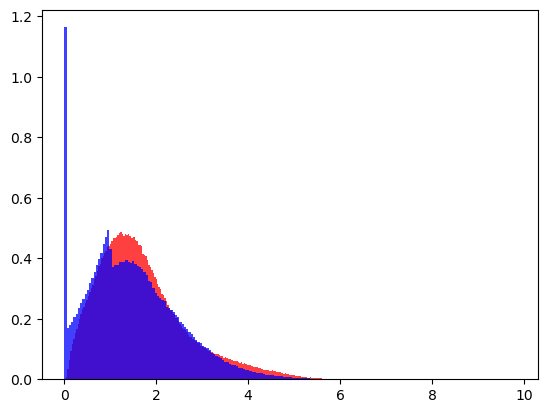

5


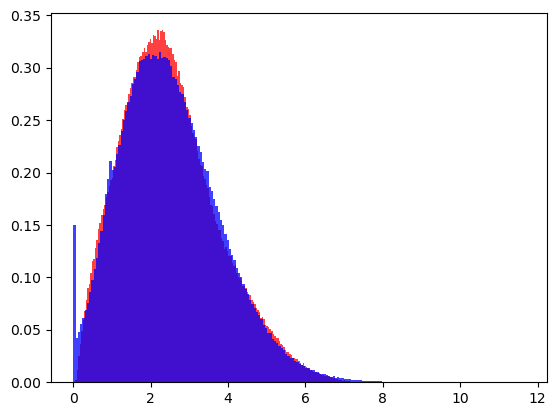

6


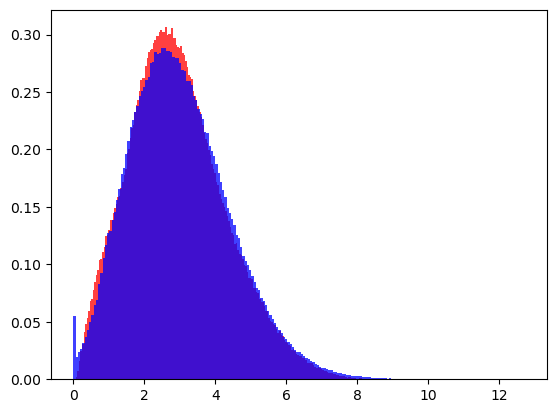

7


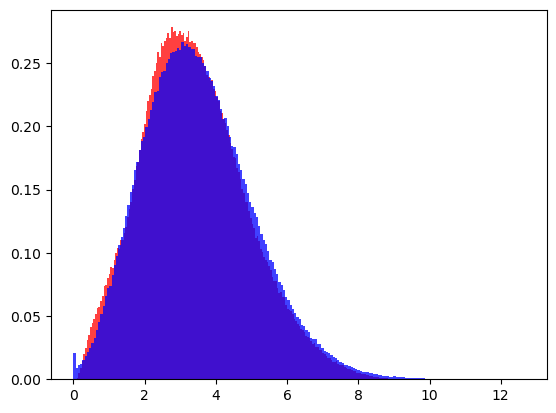

8


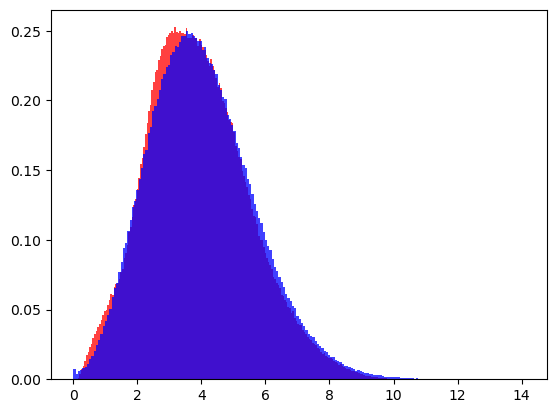

9


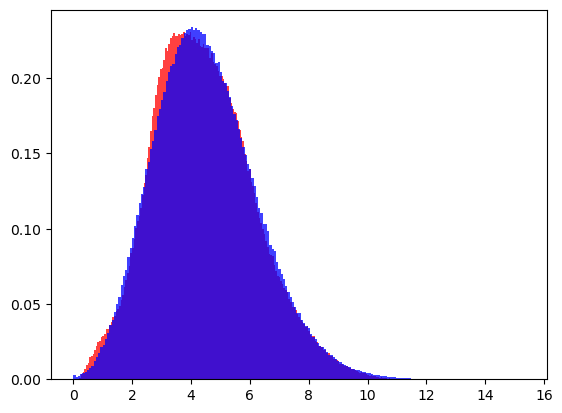

10


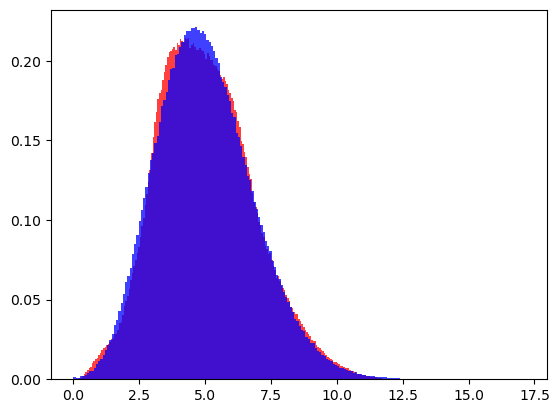

20


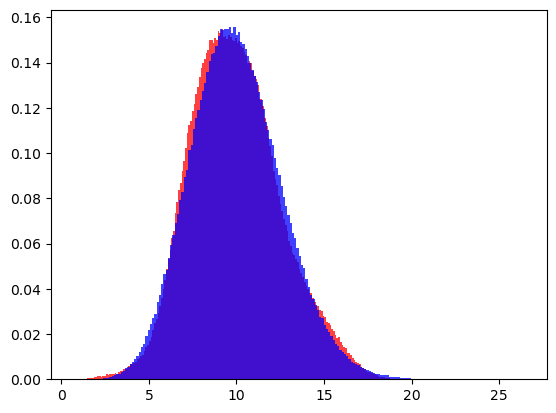

30


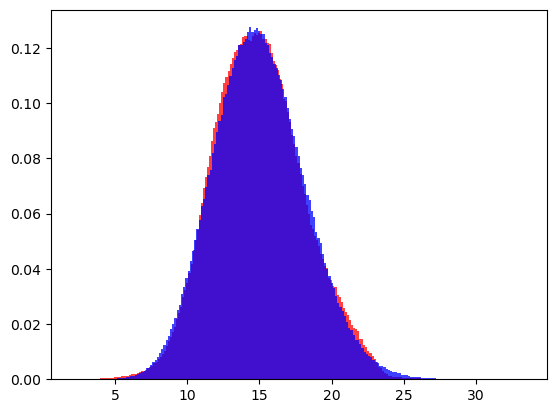

50


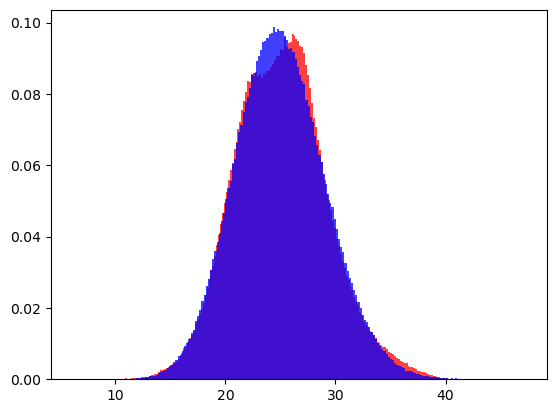

In [10]:
size  = int(1e6)
for MU in params["tested_mus"] :
    print(MU)
    np_poissonComp = true_poissonComp(mu = MU, size = size, device = torch.device('cuda:0'))
    GAN_poissonComp = PoissonComp_generator(G = poissonComp_generator, mu = MU, size = size, M = M, **params)
    GAN_poissonComp = GAN_poissonComp.detach().cpu().numpy()
    plt.hist(GAN_poissonComp, bins=200, alpha=0.75, color = 'red', density=True, label="Simulated distribution")
    plt.hist(np_poissonComp, bins=200, alpha=0.75, density=True, color = 'blue', label="Simulated distribution")
    plt.show()


Call the best model. max_mu depends on the training (take the same) and M is equal to poisson.ppf(0.999, max_mu) (see training).

Plot histograms on tested_mus.